In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from itertools import chain

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(15)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5325,00028696_001.png,Nodule,1,28696,017Y,M,AP,3056,2544,0.139000,0.139000
4647,00023269_003.png,Atelectasis,3,23269,021Y,M,PA,2882,2762,0.143000,0.143000
1102,00005750_000.png,No Finding,0,5750,021Y,M,PA,2500,2048,0.171000,0.171000
1356,00007056_007.png,Pneumothorax,7,7056,056Y,M,PA,2992,2991,0.143000,0.143000
5209,00027861_001.png,No Finding,1,27861,048Y,F,PA,2021,2021,0.194311,0.194311
269,00001437_042.png,Atelectasis|Infiltration,42,1437,031Y,F,AP,2500,2048,0.168000,0.168000
5052,00026825_006.png,Cardiomegaly|Effusion,6,26825,034Y,F,AP,3056,2544,0.139000,0.139000
3474,00017137_003.png,Effusion,3,17137,048Y,F,PA,2546,2924,0.143000,0.143000
3423,00016876_000.png,No Finding,0,16876,041Y,F,PA,2442,2991,0.143000,0.143000
4471,00022283_029.png,No Finding,29,22283,060Y,F,AP,3056,2544,0.139000,0.139000


In [3]:
## EDA
split_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
labels = split_findings.tolist()
unique_labels = np.unique(list(chain(*labels)))
print('All Labels ({}): {}'.format(len(unique_labels), unique_labels))


# for each case (row), make a binary flag for whether this person has a disease or not
for ul in unique_labels:
    all_xray_df[ul] = all_xray_df['Finding Labels'].map(lambda finding: 1 if ul in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [4]:
# count number of diseases each person has
all_xray_df['Disease Count'] = split_findings.map(lambda x: len(x) if 'No Finding' not in x else 0)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Count
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,1


There are far more non-pneumonia cases in this dataset. This is a dataset of pneumonia in the wild, so it's not specifically for pneumonia.

In [5]:
penumonia_pos_count = len(all_xray_df[all_xray_df.Pneumonia == 1])
penumonia_neg_count = len(all_xray_df[all_xray_df.Pneumonia == 0])
print('Patients positive for pneumonia', penumonia_pos_count)
print('Patients negative for pneumonia', penumonia_neg_count)

Patients positive for pneumonia 1431
Patients negative for pneumonia 110689


We see that pneumonia often co-occurs with another disease(s), or is identified as a possible alternative to another diseases 77% of the time.

In [6]:
pneumonia_and_other = len(all_xray_df.loc[(all_xray_df.Pneumonia == 1) & (all_xray_df['Disease Count'] > 1)])
print('Patients positive for pneumonia and another disease', pneumonia_and_other)
print('Proportion', pneumonia_and_other / penumonia_pos_count)

Patients positive for pneumonia and another disease 1109
Proportion 0.7749825296995109


Pneumonia occurs 1.3% of the time in the dataset.

In [7]:
(all_xray_df[unique_labels].sum()/len(all_xray_df)).sort_values(ascending=False)

No Finding            0.538361
Infiltration          0.177435
Effusion              0.118775
Atelectasis           0.103095
Nodule                0.056466
Mass                  0.051570
Pneumothorax          0.047289
Consolidation         0.041625
Pleural_Thickening    0.030191
Cardiomegaly          0.024759
Emphysema             0.022440
Edema                 0.020540
Fibrosis              0.015037
Pneumonia             0.012763
Hernia                0.002025
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

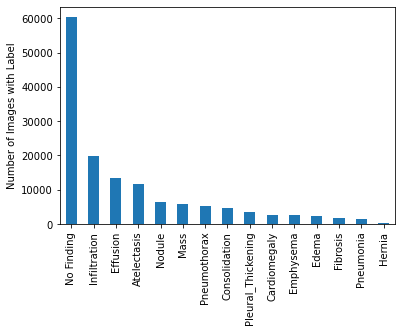

In [8]:
disease_barchart = all_xray_df[unique_labels].sum().sort_values(ascending=False).plot(kind='bar')
disease_barchart.set(ylabel = "Number of Images with Label")

Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences with penumonia. We see pneumonia is often identified along with infiltration and edema. Indeed, pulmonary infiltrates are associated with pneumonia and inflammation due to pneumonia causes fluid leakage and buildup which resembles edema.

Pneumonia                                                   322
Infiltration|Pneumonia                                      199
Edema|Infiltration|Pneumonia                                137
Atelectasis|Pneumonia                                       108
Edema|Pneumonia                                              83
                                                           ... 
Atelectasis|Cardiomegaly|Effusion|Infiltration|Pneumonia      1
Cardiomegaly|Consolidation|Effusion|Pneumonia                 1
Emphysema|Infiltration|Pleural_Thickening|Pneumonia           1
Edema|Infiltration|Mass|Nodule|Pneumonia                      1
Effusion|Emphysema|Infiltration|Pneumonia                     1
Name: Finding Labels, Length: 142, dtype: int64


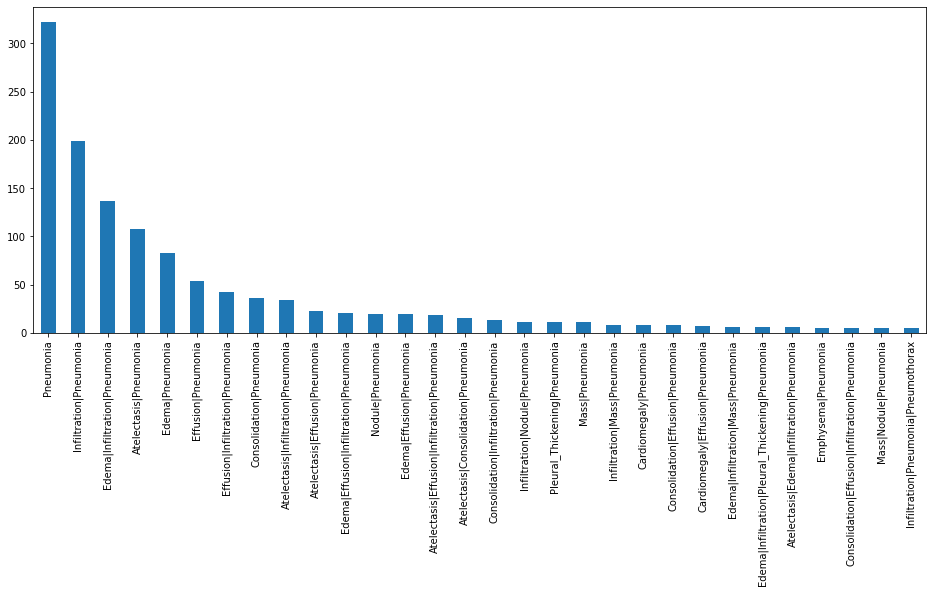

In [9]:
plt.figure(figsize=(16,6))
pneumonia_cooccurences = all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()
print(pneumonia_cooccurences)
pneumonia_cooccurences[0:30].plot(kind='bar')

First filter out the outlier ages (four hundreds).

In [10]:
# patient age
print(all_xray_df['Patient Age'].value_counts()) # we see there are outliers
print('Min age', all_xray_df['Patient Age'].min())
print('Max age', all_xray_df['Patient Age'].max())

58     3209
56     2916
52     2891
55     2830
57     2771
       ... 
411       1
413       1
414       1
95        1
152       1
Name: Patient Age, Length: 107, dtype: int64
Min age 1
Max age 414


In [11]:
from scipy import stats
all_xray_df = all_xray_df[(np.abs(stats.zscore(all_xray_df['Patient Age'])) < 3)] # remove outliers
print(all_xray_df['Patient Age'].value_counts().sort_values())
print('Min age', all_xray_df['Patient Age'].min())
print('Max age', all_xray_df['Patient Age'].max())
print('25th quantile age', all_xray_df["Patient Age"].quantile(0.25))
print('75th quantile age', all_xray_df["Patient Age"].quantile(0.75))

95       1
92       6
94       8
93       9
91      11
      ... 
57    2771
55    2830
52    2891
56    2916
58    3209
Name: Patient Age, Length: 95, dtype: int64
Min age 1
Max age 95
25th quantile age 35.0
75th quantile age 59.0


Now, we see that the dataset contains patients from 1 year old up to 95, with most 20-60 years old.

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

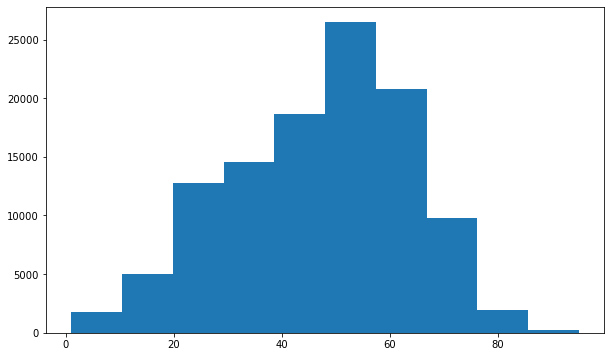

In [12]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins=10)

Most patients with penumonia are between 20 and 70.

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

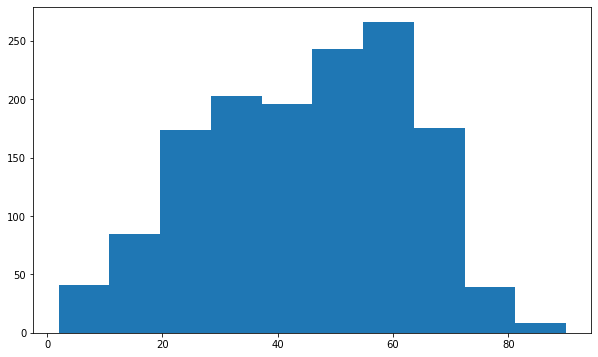

In [13]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=10)

(array([ 429.,  929., 2215., 2866., 3298., 3979., 4015., 1698.,  405.,
          57.]),
 array([ 1. , 10.3, 19.6, 28.9, 38.2, 47.5, 56.8, 66.1, 75.4, 84.7, 94. ]),
 <a list of 10 Patch objects>)

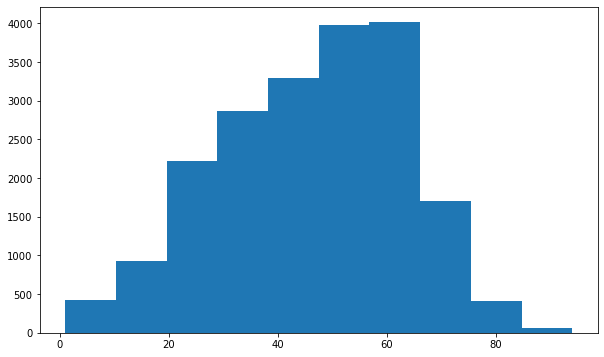

In [14]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Infiltration==1]['Patient Age'], bins=10)

(array([ 36., 101., 222., 336., 323., 358., 582., 262.,  62.,  20.]),
 array([ 3. , 11.3, 19.6, 27.9, 36.2, 44.5, 52.8, 61.1, 69.4, 77.7, 86. ]),
 <a list of 10 Patch objects>)

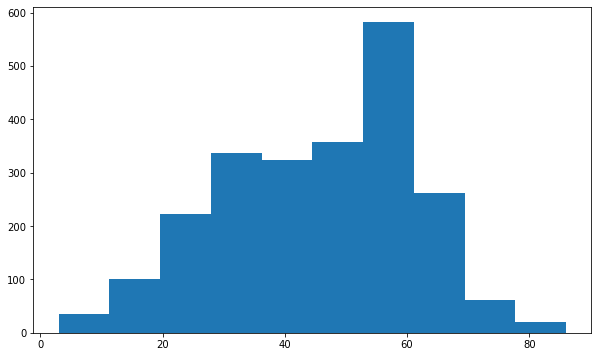

In [15]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Edema==1]['Patient Age'], bins=10)

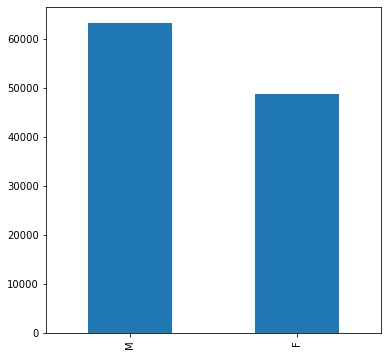

In [16]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

Pneumonia and conditions associated with pneumonia seem to affect men slightly more often than women.

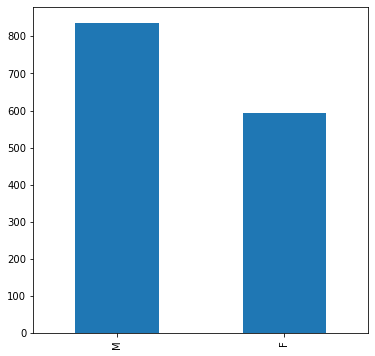

In [17]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')

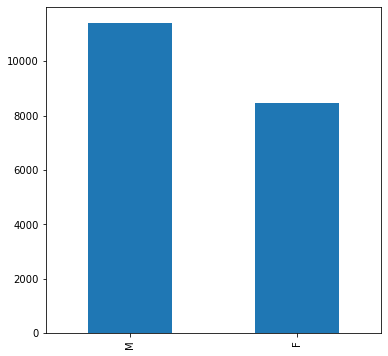

In [18]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Infiltration ==1]['Patient Gender'].value_counts().plot(kind='bar')

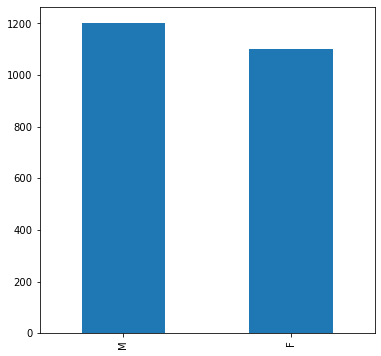

In [19]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Edema ==1]['Patient Gender'].value_counts().plot(kind='bar')

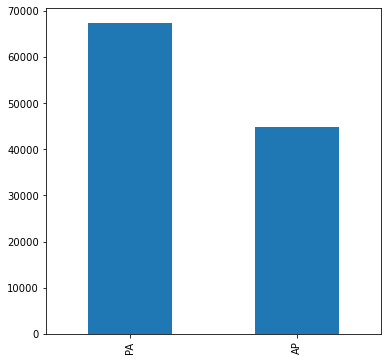

In [20]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')

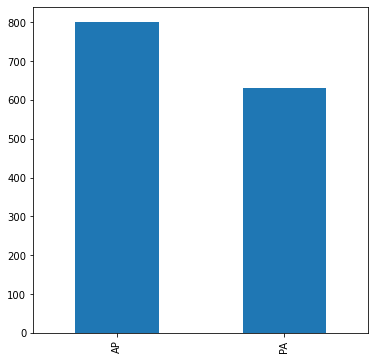

In [21]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar')

# Pixel analysis

In [22]:
!ls /data/
sample_df.sample(5)

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3448,00016992_000.png,No Finding,0,16992,014Y,M,PA,2830,2777,0.143,0.143
4918,00025923_001.png,Infiltration|Nodule,1,25923,045Y,F,PA,2992,2991,0.143,0.143
4346,00021457_033.png,Effusion,33,21457,034Y,M,AP,3056,2544,0.139,0.139
633,00003282_001.png,No Finding,1,3282,042Y,M,PA,2048,2500,0.171,0.171
4592,00022893_000.png,No Finding,0,22893,030Y,F,PA,2992,2833,0.143,0.143


In [23]:
imgs = glob('/data/images*/*/*')
# '/data/images_###/images/' is 23 characters long, so get all characters from index 24 till end to 
# extract the filename and create a mapping between filename and path (filenames are unique)
img2path = {path[24:] : path for path in imgs}

# filenames are unique
sample_df["Image Index"].value_counts().max()

1

/data/images_001/images/00000013_005.png


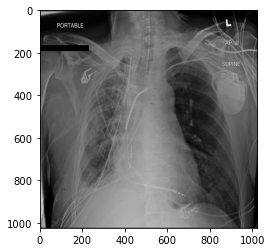

In [40]:
sample_img_path = img2path[sample_df["Image Index"].tolist()[0]]
print(sample_img_path)
sample_image = mpimg.imread(sample_img_path)
plt.imshow(sample_image, cmap="gray")

In [25]:
split_findings = sample_df['Finding Labels'].map(lambda x: x.split('|'))
labels = split_findings.tolist()
unique_labels = np.unique(list(chain(*labels)))
print('All Labels ({}): {}'.format(len(unique_labels), unique_labels))

# for each case (row), make a binary flag for whether this person has a disease or not
for l in unique_labels:
    sample_df[l] = sample_df['Finding Labels'].map(lambda finding: 1 if l in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4556,00022766_000.png,Atelectasis|Infiltration,0,22766,033Y,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0
161,00000938_004.png,Atelectasis|Effusion|Infiltration,4,938,058Y,F,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,0,0
984,00005132_000.png,No Finding,0,5132,056Y,F,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0


In [26]:
def standardize_img(img):
    mean = np.mean(img)
    std = np.std(img)
    img_copy = img.copy()
    img_copy = (img_copy - mean) / std
    return img_copy

Pneumonia positive samples 62


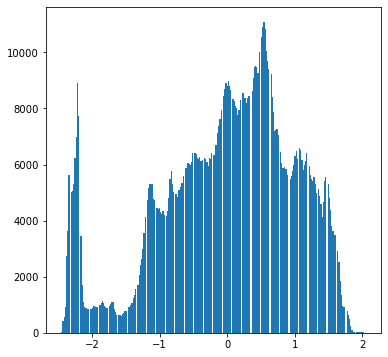

In [38]:
pneumonia_imgs = sample_df[sample_df.Pneumonia == 1]["Image Index"]
print('Pneumonia positive samples', len(pneumonia_imgs))
pneumonia_pos_filepath = img2path[pneumonia_imgs.tolist()[3]]
pneumonia_pos_image = mpimg.imread(pneumonia_pos_filepath)

pneumonia_pos_image_normalized = standardize_img(pneumonia_pos_image)

plt.figure(figsize=(6,6))
plt.hist(pneumonia_pos_image_normalized.ravel(), bins=256);

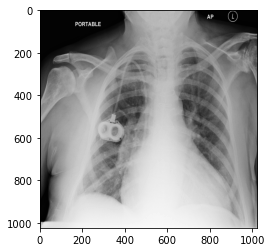

In [28]:
plt.imshow(pneumonia_pos_image, cmap="gray")

Pneumonia negative samples 5544


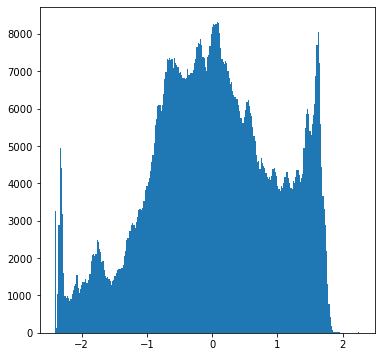

In [29]:
pneumonia_neg_imgs = sample_df[sample_df.Pneumonia == 0]["Image Index"]
print('Pneumonia negative samples', len(pneumonia_neg_imgs))
pneumonia_neg_filepath = img2path[pneumonia_neg_imgs.tolist()[9]]
pneumonia_neg_image = mpimg.imread(pneumonia_neg_filepath)

pneumonia_neg_image_normalized = standardize_img(pneumonia_neg_image)

plt.figure(figsize=(6,6))
plt.hist(pneumonia_neg_image_normalized.ravel(), bins=256);

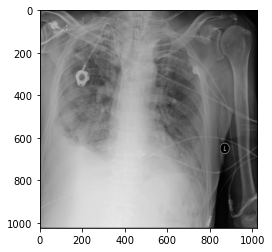

In [30]:
plt.imshow(pneumonia_neg_image, cmap="gray")

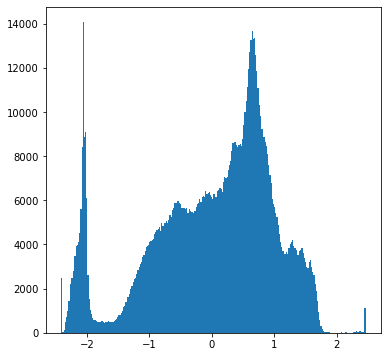

In [31]:
healthy_imgs = sample_df[sample_df['Finding Labels']=='No Finding']["Image Index"]
healthy_img_filepath = img2path[healthy_imgs.tolist()[1]]
healthy_image = mpimg.imread(healthy_img_filepath)

healthy_image_normalized = standardize_img(healthy_image)

plt.figure(figsize=(6,6))
plt.hist(healthy_image_normalized.ravel(), bins=256);

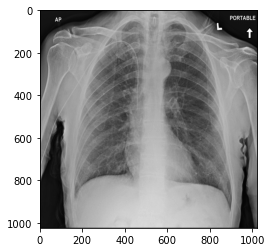

In [32]:
plt.imshow(healthy_image, cmap="gray")

In [33]:
mean_intensities_positive = []
for img in pneumonia_imgs:
    pneumonia_pos_image = mpimg.imread(img2path[img])
    mean_intensities_positive.append(np.mean((pneumonia_pos_image)))
    
mean_intensities_healthy = []
for img in healthy_imgs:
    healthy_image = mpimg.imread(img2path[img])
    mean_intensities_healthy.append(np.mean((healthy_image)))
    
mean_intensities_negative = []
for img in pneumonia_neg_imgs:
    negative_image = mpimg.imread(img2path[img])
    mean_intensities_negative.append(np.mean((negative_image)))

0.49207434


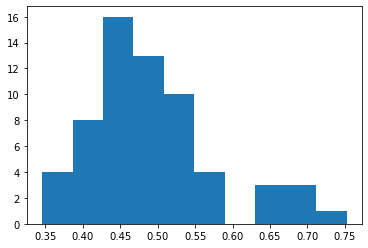

In [34]:
print(np.mean(mean_intensities_positive))
plt.hist(mean_intensities_positive, bins=10);

0.50725627


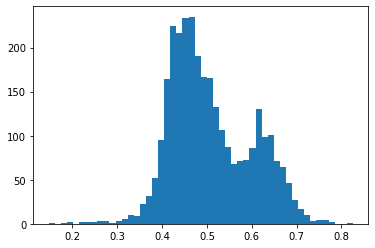

In [35]:
print(np.mean(mean_intensities_healthy))
plt.hist(mean_intensities_healthy, bins=50);

0.4988133


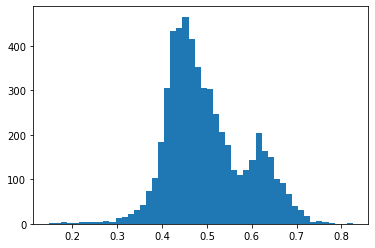

In [36]:
print(np.mean(mean_intensities_negative))
plt.hist(mean_intensities_negative, bins=50);

There is no discernible difference in pixel intensities between pneumonia positive, negative, or healthy images.